# SELECT A DAY 
This module is designed to to select any day and generate a csv demand file to used to generate and allocate mode choices. Efforts have already been made to generate a high, medium and low day of every month to be used for exploration and simulation. If you would like to generate a new demand file to explore feel free to explore the data and go to ***Pick A Day*** section and generate as needed.

```python
def pick_day(demand, 
             date,
             level):
```
> - ***demand:*** DataFrame -  is the demand for half of for 2017 and 2018 
> - ***date:*** String - is the date you would like to select in format YYYY-MM-DD no 0 padding 
> - ***level:*** String - High, medium and low category

In [179]:
from __future__ import print_function
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, SubElement, Comment
from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from datetime import datetime
sys.path.insert(0, os.path.abspath('../Generate_SUMO_demand/'))
import DFW_gen_flow as gf
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import ToggleButtons



In [180]:
demand = pd.read_csv("../Example_Files/athena_sumo_v1.csv")
selected = pd.read_csv("selected_demand.csv")


In [181]:

this_folder = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))


In [182]:
def pick_day(demand, date,level):
    """
    generates the exact day you select from the format YYYY-MM-DD
    """
    assert date in set(demand['Date']), "Check to make sure Date is in Format YYYY-MM-DD no 0 padding (e.g. 2018-6-1)"
    completed = set(selected['Date'])
    
    day = demand.loc[(demand['Date'] == date)]
    day.set_index('time',inplace=True)
    file_name = date + "." + level + ".cars.csv"
    folder = "../Example_Files/Demand_CSV"
    day.to_csv(os.path.join(folder,file_name))
    return day, date
def create_weekday(date):
    return datetime.strptime(date,'%Y-%m-%d').strftime('%A')
    
def create_month(date):
    return datetime.strptime(date,'%Y-%m-%d').strftime('%B')

def generateNumberOfPeople(df,peoplePerCar = 1.7):
    terminals = ['A','B','C','D','E']
    people = df[terminals].sum().sum() * peoplePerCar
    singleDrivers = df[['parking','pass']].sum().sum()
    total = round(people + singleDrivers)
    cars = df['Total'].sum()
    print(total,'people vs.',cars,"cars")
    return total

def create_percentile(volume):
    return round(100 * grouped['Total'].rank(method='first')/grouped.shape[0])


def convertToDateTime(string):
    return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")

def convertDTtoDay(dt):
    return str(dt.year) + "-" + str(dt.month) + "-" + str(dt.day)

def combineTrips(trips,fileOutput,this_folder):
    xroutes = Element('routes')
    xroutes.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
    xroutes.set('xsi:noNamespaceSchemaLocation', 'http://sumo.dlr.de/xsd/routes_file.xsd')
    trip_list = []
    for trip in trips:
        path_file = os.path.join(this_folder, trip)
        root_tree = ET.parse(path_file).getroot()
        trip_list.extend(root_tree)
    trip_list[:] = sorted(trip_list, key=lambda child: (child.tag,float(child.get('depart'))))
    
    xroutes.extend(trip_list)

    
    print("Saving to xml: ", fileOutput)
    configfile = os.path.join(fileOutput)
    with open(configfile, 'wb') as f:
        f.write(minidom.parseString(ET.tostring(xroutes)).toprettyxml(encoding="utf-8"))
        
def scale_vehicles(df,years,growth=1.03):
    scale = growth ** years
    scaled = day[cta].multiply(scale).round()
    scaled.index = df.index
    return scaled

In [183]:
cta = ['A','B','C','D','E','pass','parking']
demand['DateTime'] = demand['scheduled_fight_time'].apply(convertToDateTime) 
demand['Date'] = demand['DateTime'].apply(convertDTtoDay)
demand['Total'] = demand[cta].sum(axis=1)
demand.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,time,month,day,year,DateTime,Date,Total
0,2017-10-01 00:00:00,15.0,33.0,43,24,48,28,3,00:00:00,10,1,2017,2017-10-01 00:00:00,2017-10-1,194.0
1,2017-10-01 00:30:00,23.0,21.0,25,14,27,13,2,00:30:00,10,1,2017,2017-10-01 00:30:00,2017-10-1,125.0
2,2017-10-01 01:00:00,15.0,15.0,13,7,14,7,1,01:00:00,10,1,2017,2017-10-01 01:00:00,2017-10-1,72.0
3,2017-10-01 01:30:00,11.0,10.0,12,7,14,6,1,01:30:00,10,1,2017,2017-10-01 01:30:00,2017-10-1,61.0
4,2017-10-01 02:00:00,11.0,12.0,14,8,14,9,1,02:00:00,10,1,2017,2017-10-01 02:00:00,2017-10-1,69.0


# Pick A Day

In [185]:
Date = '2018-6-11'
level = 'High'
day = pick_day(demand, Date,level)

In [186]:
grouped = demand.groupby("Date").sum()
grouped.reset_index(level=0, inplace=True)
grouped['DayOfWeek'] = grouped['Date'].apply(create_weekday)
grouped.index = grouped.Date
grouped['month'] = grouped['Date'].apply(create_month)
grouped.index = grouped.Date
grouped['percentile'] = create_percentile(grouped['Total'])
grouped.drop(columns=['Date'],inplace=True)
months = grouped['month'].unique()
no_outlier = grouped[grouped['Total'] < 90000]
mean = round(np.mean(no_outlier.Total))
standard_deviation = round(np.std(no_outlier.Total))
deviation_upper= mean + standard_deviation
deviation_lower = mean - standard_deviation
minimum = np.min(grouped['Total'])
maximum = np.max(grouped['Total'])
print("Mean value of",mean)
print("Standard Deviation of", standard_deviation)
print("First deviation is between",deviation_lower,"and",deviation_upper)
print("Max volume",maximum)
print("minmum volume",minimum)

Mean value of 57261
Standard Deviation of 8307
First deviation is between 48954 and 65568
Max volume 107032.0
minmum volume 32595.0


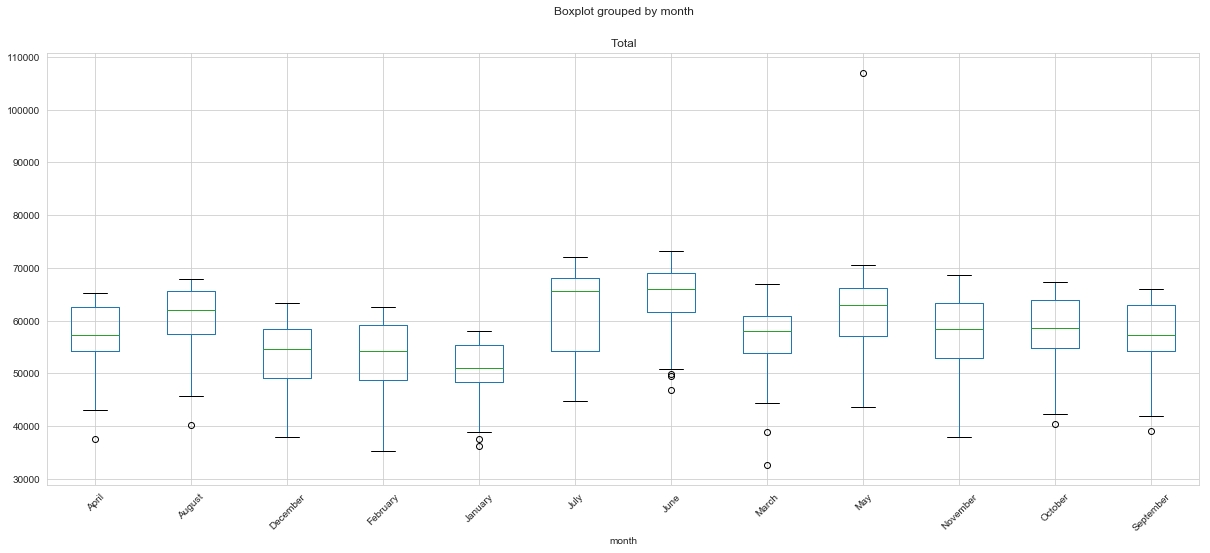

In [187]:
grouped.boxplot(column=['Total'],by='month',figsize=(20,8),rot=45)

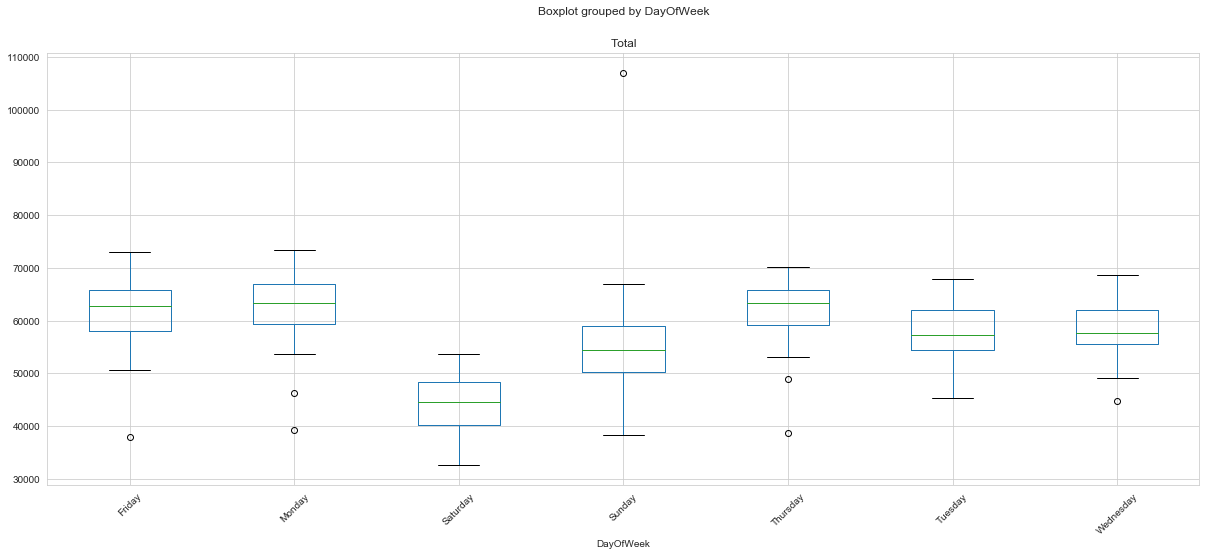

In [188]:

grouped.boxplot(column=['Total'],by='DayOfWeek',figsize=(20,8),rot=45)

<Figure size 1440x576 with 0 Axes>

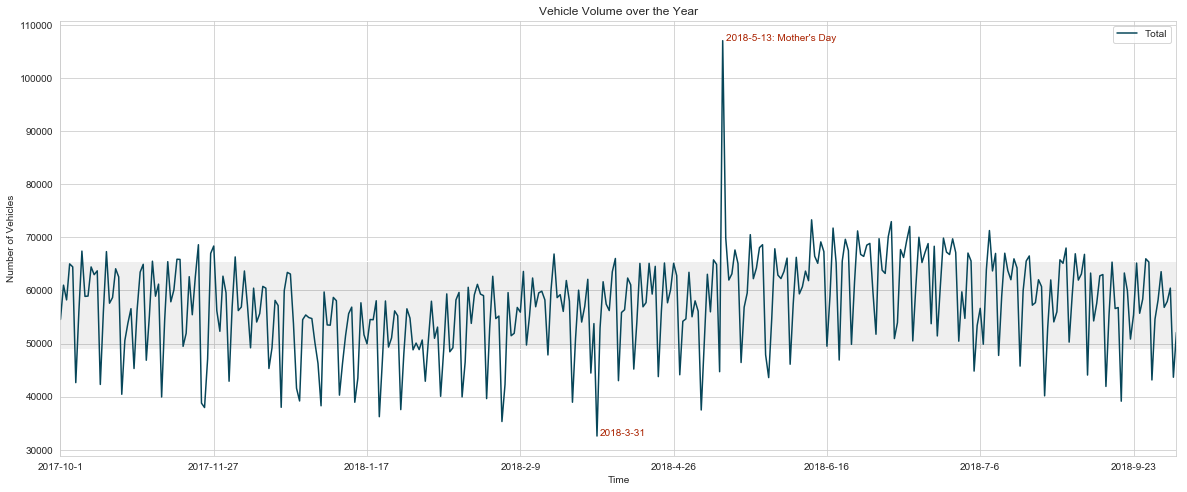

In [189]:
import hvplot.pandas 


plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
ax = demand[['Total','Date']].groupby("Date").sum().plot(figsize=(20,8),color="#074659")
ax.fill_between(ax.get_xlim(),deviation_upper , deviation_lower , facecolor='#05050510')
max_value = maximum
string_max = grouped['Total'].idxmax() + ": Mother's Day"
index_max = np.argmax(list(grouped['Total'])) +1
plt.text(index_max, max_value, string_max, color="#aa2200")
min_value = minimum
string_min = grouped['Total'].idxmin() 
index_min = np.argmin(list(grouped['Total'])) +1
plt.text(index_min, min_value, string_min, color="#aa2200")
plt.legend()
plt.title("Vehicle Volume over the Year")
plt.xlabel("Time")
plt.ylabel("Number of Vehicles")
plt.show()

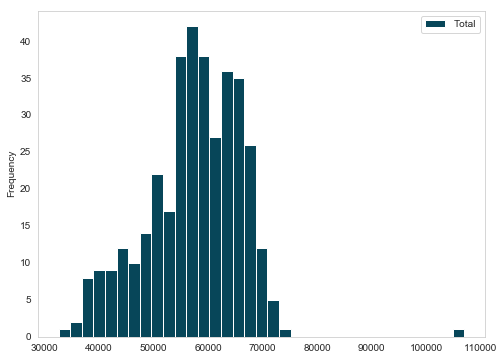

In [190]:
demand[['Total','Date']].groupby("Date").sum().plot.hist(figsize=(8,6),bins=35,color="#074659",grid=False)

In [193]:
@interact
def show_percentiles(
                    Filter=months,
                    Sort=cta,
                    Order=['Ascending','Descending']):
    if Order == 'Ascending':
        ascending = True
    else:
        ascending = False
    df = grouped[cta].loc[grouped["month"].isin([Filter])].sort_values(by=Sort,ascending=ascending)
    dates = df.index.unique()
    
    return df

interactive(children=(Dropdown(description='Filter', options=('October', 'November', 'December', 'January', 'F…

In [195]:
@interact
def show_percentiles(
                    Filter=grouped['DayOfWeek'].unique(),
                    Sort=cta,
                    Order=['Ascending','Descending']):
    if Order == 'Ascending':
        ascending = True
    else:
        ascending = False
    df = grouped[cta].loc[grouped['DayOfWeek'].isin([Filter])].sort_values(by=Sort,ascending=ascending)
    dates = df.index.unique()
    
    return df

interactive(children=(Dropdown(description='Filter', options=('Sunday', 'Tuesday', 'Wednesday', 'Thursday', 'F…

# Select A Day

In [196]:
Date = '2018-6-11' # example '2018-5-13'
day,date = pick_day(demand, Date,'high')
day.head()

,scheduled_fight_time,parking,pass,A,B,C,D,E,month,day,year,DateTime,Date,Total
time,,,,,,,,,,,,,,
00:00:00,2018-06-11 00:00:00,17.0,26.0,168,98,177,105,10,6,11,2018,2018-06-11 00:00:00,2018-6-11,601.0
00:30:00,2018-06-11 00:30:00,8.0,15.0,124,64,134,50,8,6,11,2018,2018-06-11 00:30:00,2018-6-11,403.0
01:00:00,2018-06-11 01:00:00,13.0,16.0,96,53,116,65,7,6,11,2018,2018-06-11 01:00:00,2018-6-11,366.0
01:30:00,2018-06-11 01:30:00,9.0,22.0,80,45,94,40,5,6,11,2018,2018-06-11 01:30:00,2018-6-11,295.0
02:00:00,2018-06-11 02:00:00,16.0,14.0,58,35,69,31,4,6,11,2018,2018-06-11 02:00:00,2018-6-11,227.0


In [197]:
day = demand.loc[demand['Date']=='2018-6-11']
demand['date'] = demand.Date
day = demand.loc[demand['Date']==Date]
day.index = day.time
day.hvplot(x='time',y=cta,figsize=(20,8),rot=45,height=400,width=1000,grid=True)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

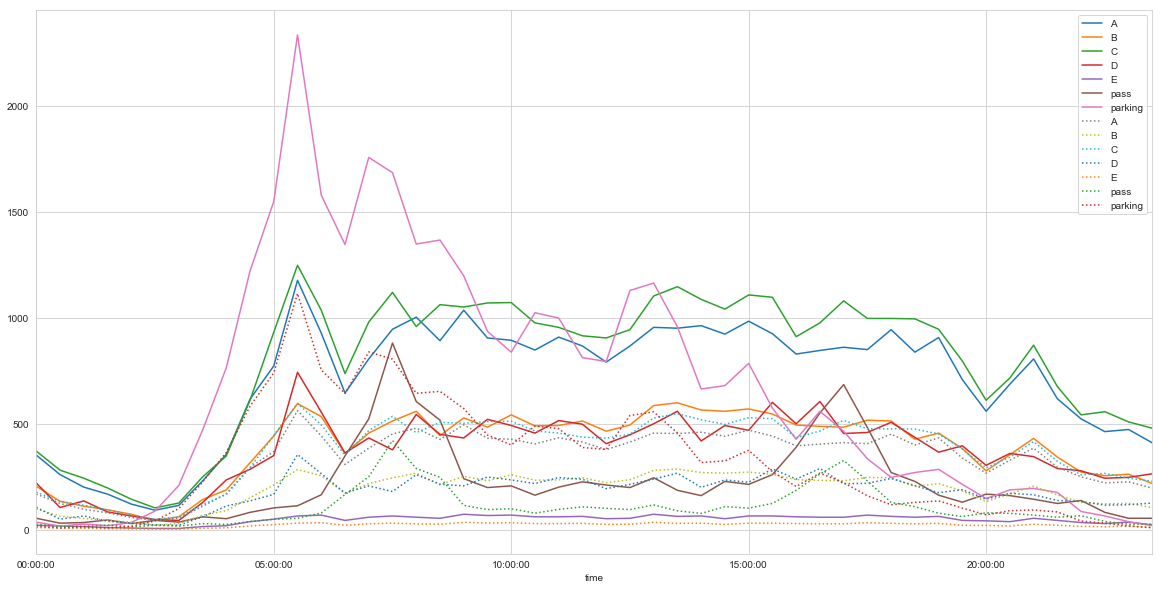

In [198]:
scaled = scale_vehicles(day,25)
ax = scaled.plot(figsize=(20,10),grid=True)
day[cta].plot(ax=ax,style=':')

In [199]:
file_name = Date + ".cars.csv"
folder = "../Example_Files/SUMO_Input_Files"
day.to_csv(os.path.join(folder,file_name))

In [200]:
people = generateNumberOfPeople(day)

110376.0 people vs. 73306.0 cars


In [170]:
gf.model_to_sumo(this_folder,day,Date,True,.25)
currentTrip = "trip_" + Date +".xml"

you chose to impliment the policy!
Saving to xml:  trip_Policy_25.0_2018-6-11.xml


In [171]:
TripFiles = ['../Example_Files/SUMO_Input_Files/RandomBus_Jan-07-20.xml',
             '../Example_Files/SUMO_Input_Files/SampleBus.xml',
             'trip_Policy_25.0_2018-6-11.xml']

CombineTripName = "CombinedCurbBus25.trips.xml" # Insert name Here
combineTrips(TripFiles,CombineTripName,this_folder)

Saving to xml:  CombinedCurbBus25.trips.xml


In [146]:
'''
<configuration>
    <input>
        <net-file value="../Example_Files/SUMO_Input_File/DFW.net.xml"/>
        <route-files value="CombinedCurbBus.trips.xml"/>
        <additional-files value="../Example_Files/SUMO_Input_File/additional_2012-12-11.xml"/>
    </input>
</configuration>
'''

'\n<configuration>\n    <input>\n        <net-file value="../Example_Files/SUMO_Input_File/DFW.net.xml"/>\n        <route-files value="CombinedCurbBus.trips.xml"/>\n        <additional-files value="../Example_Files/SUMO_Input_File/additional_2012-12-11.xml"/>\n    </input>\n</configuration>\n'